# Create a Learner for inference

In [ ]:
from fastai import *
from fastai.gen_doc.nbdoc import *

In this tutorial, we'll see how the same API allows you to create an empty [`DataBunch`](/basic_data.html#DataBunch) for a [`Learner`](/basic_train.html#Learner) at inference time (once you have trained your model) and how to call the `predict` method to get the predictions on a single item.

In [ ]:
jekyll_note("""As usual, this page is generated from a notebook that you can find in the docs_srs folder of the
[fastai repo](https://github.com/fastai/fastai). We use the saved models from [this tutorial](/tutorial.data.html) to
have this notebook run fast.
""")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>As usual, this page is generated from a notebook that you can find in the docs_srs folder of the
[fastai repo](https://github.com/fastai/fastai). We use the saved models from [this tutorial](/tutorial.data.html) to
have this notebook run fast.
</div>

## Vision

To quickly get acces to all the vision functions inside fastai, we use the usual import statements.

In [ ]:
from fastai import *
from fastai.vision import *

### A classification problem

Let's begin with our sample of the MNIST dataset.

In [ ]:
mnist = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)

It's set up with an imagenet structure so we use it to split our training and validation set, then labelling.

In [ ]:
data = (ImageItemList.from_folder(mnist)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch()
        .normalize(imagenet_stats)) 

Now that our data has been properly set up, we can train a model. Once the time comes to deploy it for inference, we'll need to save the information this [`DataBunch`](/basic_data.html#DataBunch) contains (classes for instance), to do this, we call `data.export()`. This will create an 'export.pkl' file that you'll need to copy with your model file if you want do deploy pn another device.

In [ ]:
data.export()

To create the [`DataBunch`](/basic_data.html#DataBunch) for inference, you'll need to use the `load_empty` method. Note that for now, transforms and normalization aren't saved inside the export file. This is going to be integrated in a future version of the library. For now, we pass the transforms we applied on the validation set, along with all relevant kwargs, and we normalize with the same statistics as during training.

Then, we use it to create a [`Learner`](/basic_train.html#Learner) and load the model we trained before.

In [ ]:
empty_data = ImageDataBunch.load_empty(mnist, tfms=tfms[1],size=32).normalize(imagenet_stats)
learn = create_cnn(empty_data, models.resnet18)
learn.load('mini_train');

You can now get the predictions on any image via `learn.predict`.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(Category 7, tensor(0), tensor([0.6870, 0.3130]))

It returns a tuple of three things: the object predicted (with the class in this instance), the underlying data (here the corresponding index) and the raw probabilities.

### A multilabel problem

Now let's try these on the planet dataset, which is a little bit different in the sense that each image can have multiple tags (and not jsut one label).

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Here each images is labelled in a file named 'labels.csv'. We have to add 'train' as a prefix to the filenames, '.jpg' as a suffix and he labels are separated by spaces.

In [ ]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .random_split_by_pct()
        .label_from_df(sep=' ')
        .transform(planet_tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

Again, we call `data.export()` to export our data object properties.

In [ ]:
data.export()

We can then create the [`DataBunch`](/basic_data.html#DataBunch) for inference, by using the `load_empty` method as before.

In [ ]:
empty_data = ImageDataBunch.load_empty(planet, tfms=tfms[1],size=32).normalize(imagenet_stats)
learn = create_cnn(empty_data, models.resnet18)
learn.load('mini_train');

And we get the predictions on any image via `learn.predict`.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(MultiCategory selective_logging;cultivation,
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 tensor([0.1923, 0.6070, 0.1862, 0.3969, 0.0471, 0.1786, 0.0220, 0.2634, 0.3177,
         0.2928, 0.1829, 0.5932, 0.3870, 0.2521]))

Here we can specify a particular theshold to consider the predictions are a hit or not. The default is 0.5 but we can change it.

In [ ]:
learn.predict(img, thresh=0.3)

(MultiCategory selective_logging;primary;partly_cloudy;cultivation;clear,
 tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]),
 tensor([0.1923, 0.6070, 0.1862, 0.3969, 0.0471, 0.1786, 0.0220, 0.2634, 0.3177,
         0.2928, 0.1829, 0.5932, 0.3870, 0.2521]))

### A regression example

For the next example, we are going to use the [BIWI head pose](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) dataset. On pictures of persons, we have to find the center of their face. For the fastai docs, we have built a small subsample of the dataset (200 images) and prepared a dictionary for the correspondance fielname to center.

In [ ]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

To grab our data, we use this dictionary to label our items. We also use the [`PointsItemList`](/vision.data.html#PointsItemList) class to have the targets be of type [`ImagePoints`](/vision.image.html#ImagePoints) (which will make sure the data augmentation is properly applied to them). When calling [`transform`](/tabular.transform.html#tabular.transform) we make sure to set `tfm_y=True`.

In [ ]:
data = (ImageItemList.from_folder(biwi)
        .random_split_by_pct()
        .label_from_func(lambda o:fn2ctr[o.name], label_cls=PointsItemList)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch()
        .normalize(imagenet_stats))

As before, the road to inference is pretty straightforward: export the data, then load an empty [`DataBunch`](/basic_data.html#DataBunch).

In [ ]:
data.export()

In [ ]:
empty_data = ImageDataBunch.load_empty(biwi, tfms=get_transforms()[1], tfm_y=True, size=(120,60)).normalize(imagenet_stats)
learn = create_cnn(empty_data, models.resnet18)
learn.load('mini_train');

And now we can a prediction on an image.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(ImagePoints (120, 60),
 tensor([[ 0.7982, -0.5515]]),
 tensor([ 0.7982, -0.5515]))

To visualize the predictions, we can use the [`Image.show`](/vision.image.html#Image.show) method.

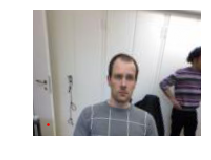

In [ ]:
img.show(y=learn.predict(img)[0])

### A segmentation example

Now we are going to look at the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) (at least a small sample of it), where we have to predict the class of each pixel in an image. Each image in the 'images' subfolder as an equivalent in 'labels' that is its segmentations mask.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We read the classes in 'codes.txt' and the function maps each image filename with its corresponding mask filename.

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

The data block API allows us to uickly get everything in a [`DataBunch`](/basic_data.html#DataBunch) and then we can have a look with `show_batch`.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

As before, we export the data then create an empty [`DataBunch`](/basic_data.html#DataBunch) that we pass to a [`Learner`](/basic_train.html#Learner).

In [ ]:
data.export()

In [ ]:
empty_data = ImageDataBunch.load_empty(camvid, tfms=get_transforms()[1], tfm_y=True, size=128).normalize(imagenet_stats)
learn = Learner.create_unet(empty_data, models.resnet18)
learn.load('mini_train');

And now we can a prediction on an image.

In [ ]:
img = data.train_ds[0][0]
learn.predict(img)

(ImageSegment (1, 128, 128), tensor([[[21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          [21, 21, 21,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]), tensor([[[2.3323e-02, 2.2946e-02, 4.6494e-03,  ..., 3.7161e-04,
           5.0104e-03, 6.4412e-03],
          [2.2634e-02, 2.0179e-02, 5.6307e-03,  ..., 2.9151e-04,
           5.1298e-03, 5.2150e-03],
          [6.2241e-03, 7.0151e-03, 3.7897e-04,  ..., 4.0918e-06,
           3.2178e-04, 4.4637e-04],
          ...,
          [9.0529e-04, 7.9842e-04, 7.6028e-05,  ..., 8.6253e-04,
           3.6710e-03, 3.6289e-03],
          [3.6277e-03, 4.0498e-03, 5.4831e-04,  ..., 3.7190e-03,
           8.8866e-03, 9.6405e-03],
          [3.8535e-03, 3.4831e-03, 6.7555e-04,  ..., 2.9442e-03,
           8.2562e-03, 7.8639e-03]],
 
         [[2.7580e-02, 2.4669e-02, 7.3161e-03,  ..., 1.1249e-03,
           9.4

To visualize the predictions, we can use the [`Image.show`](/vision.image.html#Image.show) method.

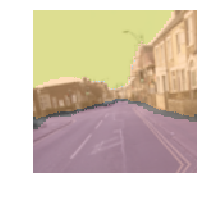

In [ ]:
img.show(y=learn.predict(img)[0])

## Text

Next application is text, so let's start by importing everything we'll need.

In [ ]:
from fastai import *
from fastai.text import *

### Language modelling

First let's look a how to get a language model ready for inference. Since we'll load the model trained in the [visualize data tutorial](/tutorial.data.html), we load the vocabulary used there.

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
vocab = Vocab(pickle.load(open(imdb/'tmp'/'itos.pkl', 'rb')))
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=vocab)
                   .random_split_by_pct()
                   .label_for_lm()
                   .databunch())

Like in vision, we just have to type `data_lm.export()` to save all the information inside the [`DataBunch`](/basic_data.html#DataBunch) we'll need. In this case, this includes all the vocabulary we created.

In [ ]:
data_lm.export()

Now let's define a language model learner from an empty data object.

In [ ]:
empty_data = TextLMDataBunch.load_empty(imdb)
learn = language_model_learner(empty_data)
learn.load('mini_train_lm');

Then we can predict with the usual method, here we can specify how many words we want the model to predict.

In [ ]:
learn.predict('This is a simple test of', n_words=20)

Total time: 00:01



'This is a simple test of these men from the " popularity of some scenes of a xxmaj gordon - xxmaj hudson and thick parts ,'

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Again we export the data.

In [ ]:
data_clas.export()

Now let's define a text classifier from an empty data object.

In [ ]:
empty_data = TextClasDataBunch.load_empty(imdb)
learn = text_classifier_learner(empty_data)
learn.load('mini_train_clas');

Then we can predict with the usual method.

In [ ]:
learn.predict('I really loved that movie!')

(Category negative, tensor(0), tensor([0.8194, 0.1806]))

# Tabular

Last application brings us to tabular data. First let's import everything we'll need.

In [ ]:
from fastai import *
from fastai.tabular import *

We'll use a sample of the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult) here. Once we read the csv file, we'll need to specify the dependant variable, the categorical variables, the continuous variables and the processors we want to use.

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = '>=50k'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

Then we can use the data block API to grab everything together before using `data.show_batch()`

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

We define a [`Learner`](/basic_train.html#Learner) object that we fit and then save the model.

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
learn.fit(1, 1e-2)
learn.save('mini_train')

Total time: 00:04
epoch  train_loss  valid_loss  accuracy
1      0.328005    0.354749    0.820000  (00:04)



As in the other applications, we just have to type `data.export()` to save everything we'll need for inference (here the inner state of each processor).

In [ ]:
data.export()

Then we create an empty data object and a learner from it like before.

In [ ]:
data = TabularDataBunch.load_empty(adult)
learn = tabular_learner(data, layers=[200,100])
learn.load('mini_train');

And we can predict on a row of dataframe that has the right `cat_names` and `cont_names`.

In [ ]:
learn.predict(df.iloc[0])

(Category 1, tensor(0), tensor([0.8100, 0.1900]))